# Survival Analysis in Cricket [DRAFT]

## Contents:

* [Introduction](#intro)


* [What's a Survival Curve?](#survival_curve)

    * [Survival Analysis in Cricket](#survival_analysis_cricket)
    

* [Experiment](#experiment)

    * [Scraping](#scraping)
    
    * [Cleaning](#data_cleaning)
    
    * [Data Transformation](#data_transformation)
    
    * [Censoring the data](#censoring_data)
        
        * [Censoring in cricket](#censoring_cricket)
        
        
* [Plotting the survival curve](#plot_survival_curve)

    * [Observations](#survival_curve_observations)
    
 
* [Plotting using country-cohorts - Further Analysis](#plot_country-cohorts)

    * [Case 1: Comparing India and Australia](#comp_ind_aus)

        * [Observations and Inferences](#ind_aus_obs_inf)
        
    * [Case 2: Comparing Pakistan and England](#comp_pak_eng)
    
        * [Observations and Inferences](#pak_eng_obs_inf)
            
    * [Can these inferences be explained by the sport itself?](#inf_sport)
        
        * [Case 1: India and Australia](#inf_sport_case1)
        
        * [Case 2: Pakistan and England](#inf_sport_case2)
      
    * [Plot all the countries](#plot_all_cohorts)
    
    
* [Plotting using era-cohorts](#plot_era-cohorts) 
    
    * [Observations and Inferences](#era_obs_inf)
    
    * [Can this be explained by the sport itself?](#era_inf_sport)
    
    
* [Plotting using player-cohorts](#plot_player-cohorts) 
    
    * [Observations and Inferences](#player_obs_inf)
    
    * [Can this be explained by the sport itself?](#player_inf_sport)


* [Survival Regression](#survival_regression) 
    
    * [Predict the survival rate of Virat Kohli](#predict_kohli)
    
    * [Predict the survival rate of Dale Steyn](#predict_steyn)


<a id='intro'></a>

## Introduction

* This notebook is about the application of Survival Analysis in cricket - to analyze the career lengths of players.

* Survival Analysis has been described in length by various resources, the following are the major soruces I used to
understand the concept:
    * Allen B. Downy's book on exploratory data analysis in Python includes a great chapter on survival curves, hazard functions, Kaplan–Meier estimators etc. 
    
    http://greenteapress.com/thinkstats2/thinkstats2.pdf 
    
    * Econometrics Academy's notes on survival analysis http://sites.google.com/site/econometricsacademy/econometrics-models/survival-analysis
     
    * Cam Davidson-Pilon's documentation on the lifelines python library on survival analysis.
    
         http://lifelines.readthedocs.org/en/latest/Quickstart.html

* Reading 'The Signal and the Noise: Why So Many Predictions Fail-but Some Don't by Nate Silver has immensely influenced my perspective about predictions in general.

http://www.amazon.com/The-Signal-Noise-Predictions-Fail-but/dp/0143125087

* Survival Analyisis is used in areas where the time duration of a sample of observations is analysed until an event of **death** occurs.
* This has great use in mechanical engineering where the lifetime of a tool/product is analyzed, medical sciences where 
the lifetime of cancer patients is analyzed etc.

<a id='survival_curve'></a>

## What's a Survival Curve?

* The basic concept of survival analysis is that of the survival function.
* The survival curve is a function that maps the durations of time t to the probablity of the sample surviving beyond 
    the time t.
* The function can also be seen as a complementary of the cumulative distribution function, as the latter maps the
    the durations to the probability of the sample surviving less than time t.

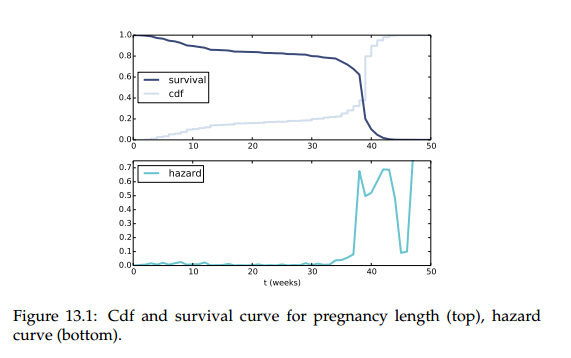

In [1]:
from IPython.display import Image
Image(filename='C:/Users/Keshav/Desktop/survival_curve.png') 

* The above image shows an example of a survival curve of a sample population of 11189 pregnancies, where the pregnancy lenghts( in weeks) are mapped to the probablity of surviving beyond the time t.
* For example, the survival function S[13] = 0.86 means that there is 86% probability that the pregnancies last beyond
    13 weeks. 
* Similarily, the cdf CDF[13] = 0.14 means that there is 14 % probability that the pregnancies don't extend beyond 13 weeks.
* Image source: Think Stats, Pg.180, Fig 13.1

* The duration depends on the definition of 'death' taken - In the above case, the definition of death is the
    event of the completion of pregnancy - rather ironic that this event is defined as *death*.

<a id='survival_analysis_cricket'></a>

### Survival Analysis in Cricket
* This is an attempt to extend this statistical concept into the field of cricket - to analyze the career lengths of players.

* The event of death in this case is the event when players retire from active cricket.
* I have tried to analyze all the players who have played ODI cricket. 
* The reason Test cricket wasn't chosen is due to the fact there is too much noise in the data due to the careers of the players marred due to the World Wars, Apartheid Crisis, Kerry Packer's cricket series etc.

<a id='experiment'></a>

## Experiment

- There isn't any readily available data when it comes to cricket yet - ESPNCricinfo (http://www.espncricinfo.com/) still doesn't provide an API to use its StatsGuru (http://stats.espncricinfo.com/ci/engine/stats/index.html) database machine - so I had to scrape the data from the Statsguru webpages to acquire the data.
- The Statsguru URL scraped is: http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;filter=advanced;orderby=runs;page=1;size=200;template=results;type=batting

In [2]:
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import pandas as pd
import lifelines
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

<a id='scraping'></a>

### Scraping
The following method scrapes the required data from the webpages. 

In [3]:
statsguru_query_url = 'http://stats.espncricinfo.com/ci/engine/stats/index.html?class=2;filter=advanced;orderby=runs;page=1;size=200;template=results;type=batting'

In [4]:
def scrape_data(page_count):
    """
    scrapes the required data present in the form of a table from the given url
    :param url: page of the ESPNCricinfo Stats URL query
    :return: the raw unicode text
    """
    url = statsguru_query_url
    complete_url = url.partition('page=1')[0] + "page=" + str(page_count) + url.partition('page=1')[-1]
    r = requests.get(complete_url)
    data = r.text
    soup = BeautifulSoup(data)
    table = soup.find_all('table')
    return table[2].text

<a id='data_cleaning'></a>

### Data Cleaning
Once the data is scraped, it has to be cleaned - stripping of the whitespaces and other noisy data to get it into a proper structure

In [5]:
def clean_data(text):
    """
    cleans the data removing all whitespaces and other data
    :param text: table text of each page
    :return: cleaned text  
    """
    text = text.split('\n')
    text.remove(u'Overall figures')
    return text

<a id='data_transformation'></a>

### Data Transformation
The data is now transformed accordingly to make get the data into a structure with which it can effectively be modelled.
A series of methods and transformations are done to make a dataframe, fit for modelling.

In [6]:
def create_data():
    """
    scrapes the data, cleans it and transforms the data to load into a pandas dataframe
    """
    page_count = 12
    df = pd.DataFrame()
    get_list_columns = lambda text, start_index, end_index: [str(unicode_text)
                                                                for unicode_text in text][start_index:end_index]
    get_data_rows = lambda text, start_index: text[start_index:]
    remove_all_occurences = lambda data, item: [x for x in data if x != item]
    get_list_rows = lambda data: [data[index: index + 13] for index, row in enumerate(data) if index % 13 == 0]
    for page in range(1, page_count + 1):
        raw_text = scrape_data(page)
        clean_text = clean_data(raw_text)
        list_columns = get_list_columns(clean_text, 3, 16)
        data_rows = get_data_rows(clean_text, 16)
        data_rows = remove_all_occurences(data_rows, u'')
        list_rows = get_list_rows(data_rows)
        df_new = pd.DataFrame(list_rows, columns=list_columns)
        if len(df) == 0:
            df = df_new
        else:
            df = pd.concat([df, df_new])
    return df

In [8]:
df_full = create_data()
df_full = df_full.reset_index(drop=True)

* The scraped data is stored in the form of a pandas dataframe.
* Since the table is updated continuously - the scraped data as on Oct 2 is saved to a  csv file for consistency.

In [13]:
df_full.to_csv('cricinfo_oct2.csv')

In [16]:
len(df_full)

2246

* There are totally 2246 players who have played ODI cricket since its inception in the 1970s.

* The following displays the first five rows of the data.
* The data is by default sorted by the amount of runs scored.

In [19]:
df_full.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (India),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (Aus/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.2,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


Renaming the columns to access them easier

In [20]:
df_full.columns = ['player', 'span', 'mat', 'inns', 'not_outs', 'runs', 'high_score', 'ave', 'bf', 'sr', 'n_100', 'n_50', 'n_0']

* Since the variable we require is the length of the player's career,we extract only two columns - the name of the player and the span(duration of career) from the original dataframe.

In [21]:
df_span = df_full[['player','span']]

In [22]:
df_span.head()

,player,span
0,SR Tendulkar (India),1989-2012
1,KC Sangakkara (Asia/ICC/SL),2000-2015
2,RT Ponting (Aus/ICC),1995-2012
3,ST Jayasuriya (Asia/SL),1989-2011
4,DPMD Jayawardene (Asia/SL),1998-2015


Information required for further analysis:
       - Career start date
       - Career end date
       - Country
   The reason being, the players can be grouped into cohorts and the survival curve of these cohorts can be compared to find any insights.

* Creating additional columns - 'career start date' and 'career end date' to 

In [23]:
# disables warning
pd.options.mode.chained_assignment = None
df_span['career_start_date'] = [int(span.partition('-')[0]) for span in df_span.span]
df_span['career_end_date'] = [int(span.partition('-')[-1]) for span in df_span.span]

In [24]:
df_span.head()

,player,span,career_start_date,career_end_date
0,SR Tendulkar (India),1989-2012,1989,2012
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015
2,RT Ponting (Aus/ICC),1995-2012,1995,2012
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015


Adding another column - 'career_length' which is obtained from subtracting the above two columns

In [25]:
calc_career_length = lambda df: [row.career_end_date - row.career_start_date + 1 for index, row in df.iterrows()]
df_span['career_length'] = calc_career_length(df_span)

In [26]:
df_span.head()

,player,span,career_start_date,career_end_date,career_length
0,SR Tendulkar (India),1989-2012,1989,2012,24
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015,16
2,RT Ponting (Aus/ICC),1995-2012,1995,2012,18
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011,23
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015,18


The country of the player has not been represented, though it has been included within the player's name. Having 
the country as a column can be quite useful.

In [27]:
get_name = lambda player : [each_player.partition(' (')[0] for each_player in player]
df_span['name'] = get_name(df_span.player)

In [28]:
get_country = lambda player: [each_player[each_player.index('(')+1:each_player.index(')')] for each_player in player]
df_span['country'] = get_country(df_span.player)

* Certain players however have played for more than 1 team - Asia/ ICC etc. Such countries don't make any change and
have to be removed.
* Certain players like Kepler Wessels, Eoin Morgan have played for more than 1 country - for sake of simplicity, 
such players are ignored as their career lengths will be longer - forming outliers.

In [29]:
remove_forward_slash = lambda country: [each_country.replace('/', '') for each_country in country]
df_span['country'] = remove_forward_slash(df_span.country)

Considering players belonging to the 'Full members' of ICC as the associate countries' data may be noisy, creating outliers

In [30]:
list_countries = lambda country : ['India' if 'India' in each_country
                 else 'SL' if 'SL' in each_country
                 else 'SA' if 'SA' in each_country
                 else 'Aus' if 'Aus' in each_country
                 else 'Pak' if 'Pak' in each_country
                 else 'WI' if 'WI' in each_country
                 else 'NZ' if 'NZ' in each_country
                 else 'Zim' if 'Zim' in each_country
                 else 'Eng' if 'Eng' in each_country
                 else 'Ban' if 'Ban' in each_country
                 else None for each_country in country]
df_span['country'] =  list_countries(df_span.country)

In [31]:
df_span = df_span[df_span.country.notnull()]

In [32]:
df_span.head()

,player,span,career_start_date,career_end_date,career_length,name,country
0,SR Tendulkar (India),1989-2012,1989,2012,24,SR Tendulkar,India
1,KC Sangakkara (Asia/ICC/SL),2000-2015,2000,2015,16,KC Sangakkara,SL
2,RT Ponting (Aus/ICC),1995-2012,1995,2012,18,RT Ponting,Aus
3,ST Jayasuriya (Asia/SL),1989-2011,1989,2011,23,ST Jayasuriya,SL
4,DPMD Jayawardene (Asia/SL),1998-2015,1998,2015,18,DPMD Jayawardene,SL


Dropping columns 'player' and 'span' from the dataframe

In [33]:
df_span = df_span.drop('player', 1)

In [34]:
df_span = df_span.drop('span', 1)

Reordering the columns

In [35]:
df_span = df_span[['name', 'country', 'career_start_date', 'career_end_date', 'career_length']]

In [36]:
df_span.head()

,name,country,career_start_date,career_end_date,career_length
0,SR Tendulkar,India,1989,2012,24
1,KC Sangakkara,SL,2000,2015,16
2,RT Ponting,Aus,1995,2012,18
3,ST Jayasuriya,SL,1989,2011,23
4,DPMD Jayawardene,SL,1998,2015,18


<a id='censoring_data'></a>

## Censoring the data

* While analyzing the durations of a sample/population, it is quite possible to find certain individuals or data 
    whose death has not occured yet - at the current time, their deaths have not yet been noticed/occured.
* When the data has this behaviour, it is said to be *right-censored*.
* It is crucial to include the censored data before modelling, as having only the non-censored data can imply different observations about the data which need not be true.
* Indeed, data for survival analysis can be viewed as a regression dataset where the outcome variable - 'censor' 
    is not defined for few rows.

<a id='censoring_cricket'></a>

### Censoring in cricket

* The event of '**death**' in this example is the event of players retiring from active cricket (ODI).
* So there are players who have not yet retired yet - who are still playing some form of active cricket or have died 
    unfortunately - Phil Hughes for instance.
* These players form the censored data in this case.
* Again, Statsguru does not provide any easy way of finding out whether players have retired or not.
* For sake of this implementation of survival curves, I have *manually* entered the censoring label for each 
    of the players.
* In this effort, I have assumed that those players who last played in 2011 or earlier have **retired**.
* The reasons for choosing 2011 are multi-fold:
    1. It's 4 years since 2015 - there is a high chance that players who last played in 2011 have retired or will never play again. Yes, there may be exceptions. 
    2. 2011 is the year of the previous World Cup which saw a number of high-profile retirements and generally, players usually draw their careers to a close after a World Cup.
    3. One more world cup has ended after 2011 - this means that teams will ideally look to build towards the next world cup, meaning those who last played in 2011 will almost never get a chance to play again. This closely is interconnected with the first reason.

In [37]:
# entering 1 intially for all players
df_span['censor'] = [1 if each_player.career_end_date <= 2011 else 0 for index,each_player in df_span.iterrows()]

* censor label : 1 means that player has retired, 0 means that the player has an active playing career.

In [38]:
#re-ordering index of dataframe
df_span.reset_index(drop=True);

In [39]:
# converting dataframe to csv to manually alter it
df_span.to_csv('censor_oct2.csv')

In [40]:
df_censor = pd.read_csv('censor_oct2.csv')

In [43]:
df_censor = df_censor.drop('Unnamed: 0', 1);

In [46]:
df_censor.head()

,name,country,career_start_date,career_end_date,career_length,censor
0,SR Tendulkar,India,1989,2012,24,1
1,KC Sangakkara,SL,2000,2015,16,1
2,RT Ponting,Aus,1995,2012,18,1
3,ST Jayasuriya,SL,1989,2011,23,1
4,DPMD Jayawardene,SL,1998,2015,18,1


The following data shows few rows of the data with its censored values.

In [47]:
df_censor.tail(12)

,name,country,career_start_date,career_end_date,career_length,censor
1742,EP Thompson,NZ,2009,2009,1,1
1743,AL Thomson,Aus,1971,1971,1,1
1744,RW Tolchard,Eng,1979,1979,1,1
1745,CM Tuckett,WI,1998,1998,1,1
1746,I Udana,SL,2012,2012,1,0
1747,JD Unadkat,India,2013,2013,1,0
1748,JM Vince,Eng,2015,2015,1,0
1749,Wahidul Gani,Ban,1988,1988,1,1
1750,KP Walmsley,NZ,2003,2003,1,1
1751,M Watkinson,Eng,1996,1996,1,1


In [48]:
df_censor.censor.value_counts().sort_index()

0     376
1    1378
Name: censor, dtype: int64

* It is thus observed that there are 376 0-censor labelled players and 1378 1-censor labelled players in the dataset.

* In other words, there are 376 active players in ODI cricket - that is an average of around 37 players for every team, considering only 10 teams are considered - wthe average length of a squad is around 15-20 - but when the fringe players are included, the count of 37 makes sense.

In [49]:
df_censor.head()

,name,country,career_start_date,career_end_date,career_length,censor
0,SR Tendulkar,India,1989,2012,24,1
1,KC Sangakkara,SL,2000,2015,16,1
2,RT Ponting,Aus,1995,2012,18,1
3,ST Jayasuriya,SL,1989,2011,23,1
4,DPMD Jayawardene,SL,1998,2015,18,1


<a id='plot_survival_curve'></a>

## Plotting the survival curve

In [50]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [51]:
kmf.fit(df_censor.career_length, event_observed=df_censor.censor)

<lifelines.KaplanMeierFitter: fitted with 1754 observations, 376 censored>

In [52]:
import plotly
import plotly.tools as tls
import plotly.plotly as py
from plotly.graph_objs import Figure, Data, Layout
import matplotlib.pyplot as plt
from plotly.graph_objs import *
%matplotlib inline
from pylab import rcParams

In [53]:
def pyplot(fig, ci=True, legend=True):
    # Convert mpl fig obj to plotly fig obj, resize to plotly's default
    py_fig = tls.mpl_to_plotly(fig, resize=True)
    
    # Add fill property to lower limit line
    if ci == True:
        style1 = dict(fill='tonexty')
        # apply style
        py_fig['data'][2].update(style1)
        
        # Change color scheme to black
        py_fig['data'].update(dict(line=Line(color='black')))
    
    # change the default line type to 'step'
    py_fig['data'].update(dict(line=Line(shape='hv')))
    # Delete misplaced legend annotations 
    py_fig['layout'].pop('annotations', None)
    
    if legend == True:
        # Add legend, place it at the top right corner of the plot
        py_fig['layout'].update(
            showlegend=True,
            legend=Legend(
                x=1.05,
                y=1
            )
        )
        
    # Send updated figure object to Plotly, show result in notebook
    return py.iplot(py_fig)

In [59]:
p = kmf.plot(ci_force_lines=True, title='Career Lengths of ODI players')
kmf1 = plt.gcf()
pyplot(kmf1)

<a id='survival_curve_observations'></a>

### Observations

In [60]:
kmf.median_

6.0

* It is observed that the probablity of the population having career of atleast 6 years is 50%. 
In other words, there are 50% chance that a player will have career atleast 6 years.

In [61]:
kmf.survival_function_.KM_estimate[20]

0.0052425761652501327

* On the other hand, there is 0.5 % chances that a player's career will extend beyond 20 years.

In [62]:
kmf.survival_function_.KM_estimate[10]

0.25652730022312326

* There is 25% chance that a player's career extends beyonds 10 years

<a id='plot_country-cohorts'></a>

## Plotting using Cohorts - Further Analysis

<a id='comp_ind_aus'></a>

### Case 1:  Comparing India and Australia

In [63]:
countries_type = df_censor['country'].unique()

In [64]:
ind = df_censor.query('country == "India"')

In [65]:
aus = df_censor.query('country == "Aus"')

In [67]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(ind.career_length, event_observed=ind.censor, label="India")
kmf.survival_function_.plot(ax=ax)
kmf.fit(aus.career_length, event_observed=aus.censor, label="Aus")
kmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers among India and Australia players ")
kmf2 = plt.gcf()
pyplot(kmf2, ci=False)

<a id='ind_aus_obs_inf'></a>

#### Observations:
* There are primarily two trends observed in the plots - 
    1. The survival curve for Australia is more than that of India between the period, 3 to 10 years.
    2. The survival curve for India dominates that of Australia from 10 years.
* The tail for Australia ends at around 17 years while for India, it extends much longer (till 24 years).

#### Inferences:
* There is a greater chance of an Australian player having a career of 3 - 10 years than an Indian player having a career of the same duration.
* There is roughly 22-25% chances that a player from either of these 2 countries will have a career of atleast 10 years.
* It's more probable that a player from India will have greater probability of having a career of 10+ years than an Australian player.
* It is highly unlikely that an Australian player will have an ODI career more than 17 years whereas the chances are much greater for an Indian player to have a career which 17 years and beyond.

<a id='comp_pak_eng'></a>

### Case 2: Comparing Pakistan and England

In [68]:
pak = df_censor.query('country == "Pak"')

In [70]:
eng = df_censor.query('country == "Eng"')

In [71]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(pak.career_length, event_observed=pak.censor, label="Pak")
kmf.survival_function_.plot(ax=ax)
kmf.fit(eng.career_length, event_observed=eng.censor, label="Eng")
kmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers among England and Pakistan players ")
kmf2 = plt.gcf()
pyplot(kmf2, ci=False)

<a id='pak_eng_obs_inf'></a>

#### Observations:
* The survival curve for both the countries seem to be almost the same till 5 years. 
* After that point, we notice that the curve seem to significantly higher for Pakistan than England.
* The survival curve continues past the duration of 20 years for India (around 22) but it tapers off for England
    at 20 itself.

#### Inferences:
* The chance of players from the sample, have a career more than 5 years is 50% for both the countries. 
* But the chance of a player from Pakistan having a career more than 10 years is around 30% whereas there's only 20% chance of a player from England having a career more than 10 years. 
* The difference becomes more conspicious when we note the chances of a player having a career more than 12-13 years.
* We notice that the probability(or chance) is approximately double in the case of Pakistan when compared to that England. 

** In other words, a player representing Pakistan is twice more likely of having a career more than 12-13 years than a player from England!**

<a id='inf_sport'></a>

### Can these inferences be explained by the sport itself?

<a id='inf_sport_case1'></a>

#### Case 1: India and Australia
* Yes - The Indian cricketers have always been given a long rope in their careers by the BCCI. 
    Even if they seem are out of form or are inconsistent, their experience has always been given more priority than their current form. Various players right from Kapil Dev to the likes of Sachin Tendulkar & Saurav Ganguly have always been given a soft spot considering their contributions and experience. 
    
* The Australian players on the hand are not so fortunate - they always have been judged based on their current form than their past records. Infact, CA (Cricket Australia) is quite famous for dropping the Waugh brothers in 2002 as their ODI contributions were dwindling. Many more examples can be made.

* The way the boards managed their respective players can be viewed as a major reason for the difference in the curves. Both the countries have boards with different mindsets - although BCCI in the recent past, have become less biased towards players with experience and are selecting players based on form.

* This single factor largely explains the inferences made from the curves.

* It makes sense that there's a greater chance of an Aussie player having a career b/w 3-10 years than an Indian player - this is because, an Indian player in majority of cases, will go on to have a career of more than 10 years, having played that long - the reason can be attributed to the role played by the boards as explained above.

* The reason for the tail of the Australian survival curve being significantly shorter than that of the Indian one also makes sense as it's very tough for a player to have a consistent career when he plays for that many years and being from Australia, it's highly unlikely that he stays in the team. The same reasoning can be explained to the tail of Indian players' survival curve being very long.

<a id='inf_sport_case2'></a>

#### Case 2 - England and Pakistan
* Similarily as explained in the previous example of Australia and India, the ECB is notorious for their *poor* management of players and selection - the ongoing standoff between ECB and Kevin Pieterson is a standing example.
* Also, many english cricketers from Marcus Trescothick, Nick Knight etc have had premature end to their careers - citing workload and stress as reasons. This factor can also be attributed to the shape of the survival curves.
* It's highly ironical that Pakistan has a significantly higher survival curve than England despite the fact that PCB is also known for their controversial selections. But if it can be observed closely, PCB has sacked captains but they have continued to play even after they are sacked. 
* This attitude can be applied for the Indian players as well. Many players, right from Sachin to Saurav to Rahul Dravid have gone on to play under new captains even after resigning their posts as captains or being sacked.
* But the Australian or English players are not like their Asian counterparts - they are known for retiring once they are sacked as captains.

<a id='plot_all_cohorts'></a>

### Plotting all the countries

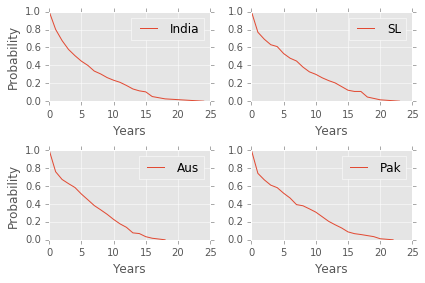

In [72]:
for i,country_type in enumerate(countries_type[:4]):
    ax = plt.subplot(2,2,i+1)
    kmf1 = KaplanMeierFitter()
    ind = df_censor[df_censor.country == country_type]
    kmf1.fit(ind.career_length, event_observed=ind.censor, label=country_type)
    kmf1.survival_function_.plot(ax=ax)
    plt.xlim(0,25)
    if i % 2 ==0:
        plt.ylabel('Probability')
    plt.xlabel("Years")
plt.tight_layout()

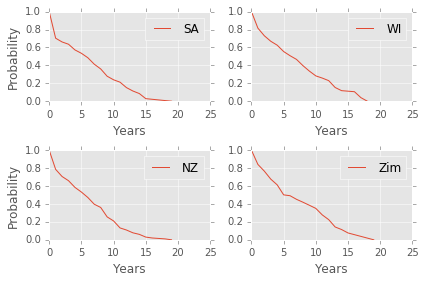

In [73]:
for i,country_type in enumerate(countries_type[4:8]):
    ax = plt.subplot(2,2,i+1)
    kmf1 = KaplanMeierFitter()
    ind = df_censor[df_censor.country == country_type]
    kmf1.fit(ind.career_length, event_observed=ind.censor, label=country_type)
    kmf1.survival_function_.plot(ax=ax)
    plt.xlim(0,25)
    if i % 2 ==0:
        plt.ylabel('Probability')
    plt.xlabel("Years")
plt.tight_layout()

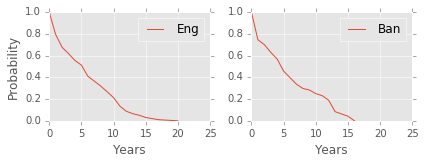

In [74]:
for i,country_type in enumerate(countries_type[8:]):
    ax = plt.subplot(2,2,i+1)
    kmf1 = KaplanMeierFitter()
    ind = df_censor[df_censor.country == country_type]
    kmf1.fit(ind.career_length, event_observed=ind.censor, label=country_type)
    kmf1.survival_function_.plot(ax=ax)
    plt.xlim(0,25)
    if i % 2 ==0:
        plt.ylabel('Probability')
    plt.xlabel("Years")
plt.tight_layout()

In [79]:
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for country in countries_type:
    df_country = df_censor[df_censor.country == country]
    kmf.fit(df_country.career_length, df_country.censor, label=country)
    ax = kmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers across all countries ")
kmf2 = plt.gcf()
pyplot(kmf2, ci=False)    

<a id='plot_era-cohorts'></a>

## Plotting using era-cohorts

* Cricket as a sport has evolved over the years. The sport we see now is a far cry from what it was during the 1980s.

* The players are divided into 3 main 'eras', based on when they made their debut:
    1. 2007 - present
    2. 1989 - 2006
    3. Start of ODI cricket - 1988

In [76]:
type_era = []
for index, row in df_censor.iterrows():
    if row.career_start_date < 1989:
        type_era.append('0')
    if row.career_start_date >= 1989 and row.career_start_date < 2007:
        type_era.append('1')
    if row.career_start_date >= 2007:
        type_era.append('2')
df_censor['type_era'] = pd.Series(type_era)

* Plotting the players, based on their eras.

In [78]:
from lifelines import KaplanMeierFitter
era_0 = df_censor.query("type_era == '0'")
era_1 = df_censor.query("type_era == '1'")
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(era_0.career_length, event_observed=era_0.censor, label="before 89")
kmf.survival_function_.plot(ax=ax)
kmf.fit(era_1.career_length, event_observed=era_1.censor, label="89-07")
kmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers among players who made their debut before 89 and 89 -'07 ")
#plt.title("Survival curve of ODI Careers among England and Pakistan players ")
kmf2 = plt.gcf()
pyplot(kmf2, ci=False)

<a id='era_obs_inf'></a>

#### Observations:
* The basic trend observed in the plot - 
    The survival curve for the players who made their debut in the period 89-2007 clearly dominates the players who made their debut before 1989 from the period, 5 years to the end - the domination is evident especially from 9 years.

#### Inferences:
* There is a greater chance for players who made their debut in the period 89-2007 to have a career length of 9 years and more than players who made their debuts before 1989.

<a id='era_inf_sport'></a>

### Can this be explained by the sport itself?

* The sport has changed drastically from the 1980s to present. 
* A major factor which can influence a player's career length is how injury prone his body is.
* The fitness standards of the player have improved over the years thanks to better coaching standards, improved player physio-support, well equipped training facilities etc.
* This probably can lengthen a player's career - especially when he has played for around 10 years or so. The improved facilities/standards can help him get back to competitive cricket quicker than it has been earlier. This probably explains the dominance of the curve from 9 years.

<a id='plot_player-cohorts'></a>

## Plotting type of player cohorts

In [80]:
df_censor_new = pd.read_csv('censor_oct2_new.csv')

In [82]:
df_censor_new = df_censor_new.drop('Unnamed: 0', 1);

In [83]:
df_censor_new.type_player.value_counts()

1    722
0    691
2     97
Name: type_player, dtype: int64

There are 722 bowlers, 691 batsmen and 97 all-rounders in this data.

* Plotting the players based on their type:

In [84]:
from lifelines import KaplanMeierFitter
bat = df_censor_new.query("type_player == 0")
bowl = df_censor_new.query("type_player == 1")
kmf = KaplanMeierFitter()
ax = plt.subplot(111)
kmf.fit(bat.career_length, event_observed=bat.censor, label="batsmen")
kmf.survival_function_.plot(ax=ax)
kmf.fit(bowl.career_length, event_observed=bowl.censor, label="bowlers")
kmf.survival_function_.plot(ax=ax)
plt.title("Survival curve of ODI Careers among batsmen and bowlers")
kmf2 = plt.gcf()
pyplot(kmf2, ci=False)

<a id='player_obs_inf'></a>

#### Observations:
* The survival curve for the batsmen is much higher than that of the bowlers.
* The tail for the batsmen extend much beyond 20 while the bowlers' curve ends by 20.

#### Inferences:
* Batsmen are expected to have a longer career than bowlers.
* The chances for the career lengths of the batsmen to have 20+ careers is more than that for the bowlers.

<a id='player_inf_sport'></a>

### Can this be explained by the sport itself?

* The role of the player in the team - batsman or bowler or all-rounder playes a huge factor in their career lengths. 
* A bowler goes through much more injuries and has to maintain high fitness standards, compared to batsmen.
* Also, throughout the history of player selections, more bowlers have been tried and tested - a large number of them dropped after playing a single series or two. The quest to find a bowling combination suited for all playing conditions continues till date,prompting the selectors to use the bowlers on a case-by-case basis. This explains the higher amount of bowlers overall and the significant difference in their career lengths.

<a id='survival_regression'></a>

## Survival Regression

* The concept of survival analysis can be used to predict the survival curves of individual subjects too. This is achieved by using regression models.

* These regression models regress the covariates( additional information obtained related to the subject) against the duration and censor information of the subject. 

* The regression models - Aalen's Additive Model and Cox's Proportional Hazards Model, estimate the hazard rate.  

* Survival Regression can be used to predict the individual survival and hazard rates. 

* These regression techniques can thus be applied on  individual players, whose career is not oer yet, to predict the possible lifetime of his career.

* The covariates used are:
    1. Country
    2. Era the player belongs to
    3. Role of player

* Using these covariates, the individual survival rates can be estimated by regressing these covariates against the known duration and censoring information.

* The Aalen Additive model is used on this dataset.

In [85]:
from lifelines import AalenAdditiveFitter

In [86]:
import pandas as pd
df_regression = pd.read_csv('censor_oct2_new.csv')
df_regression = df_regression.drop('Unnamed: 0', 1);
type_era = []
for index, row in df_regression.iterrows():
    if row.career_start_date < 1989:
        type_era.append('0')
    if row.career_start_date >= 1989 and row.career_start_date < 2007:
        type_era.append('1')
    if row.career_start_date >= 2007:
        type_era.append('2')
df_regression['type_era'] = pd.Series(type_era)
type_player = list()
for index, row in df_regression.iterrows():
    type_player.append(str(row.type_player))
df_regression['type_player'] = pd.Series(type_player)

In [87]:
import patsy
X = patsy.dmatrix('country + type_era + type_player -1', df_regression, return_type='dataframe')
aaf = AalenAdditiveFitter(coef_penalizer=1.0, fit_intercept=True)
X['T'] = df_regression.career_length
X['E'] = df_regression.censor
aaf.fit(X, 'T', event_col='E')

 [-----------------100%-----------------] 1203 of 1203 complete in 3.3 sec


<lifelines.AalenAdditiveFitter: fitted with 1510 observations, 307 censored>

<a id='predict_kohli'></a>

### Predict the survival rate of Virat Kohli

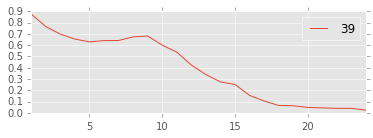

In [94]:
ix = (df_censor_new['name'] == 'V Kohli')
kohli = X[ix]
ax = plt.subplot(2,1,2)
aaf.predict_survival_function(kohli).plot(ax=ax)

<a id='predict_steyn'></a>

### Predict the survival rate of Dale Steyn

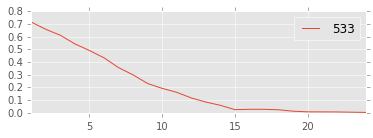

In [95]:
ix = (df_censor_new['name'] == 'DW Steyn')
steyn = X[ix]
ax = plt.subplot(2,1,2)
aaf.predict_survival_function(steyn).plot(ax=ax)

### Caveats to this regresion model

* This model takes only 3 factors into concern : 
    1. Country
    2. Era the player belongs to
    3. Role of player


* Other than these 3 factors, there are other factors which play a vital role in the lifetime of a player. They include the 
personal fitness of the player, his form/consistency, his general attitude - all which can affect his span, sometimes more than
the 3 factos taken into account.


* However, these factors are not quantifiable and even if they are, it is very difficult to generate such data for all the players.


* Under these limitations of the model, it may look like for example, any Indian batsman who makes his debut after 2007 will have the same survival rate as that of  Virat Kohli.


* But if further factors are taken into concern, then the survival rates will be very different and can be more useful.